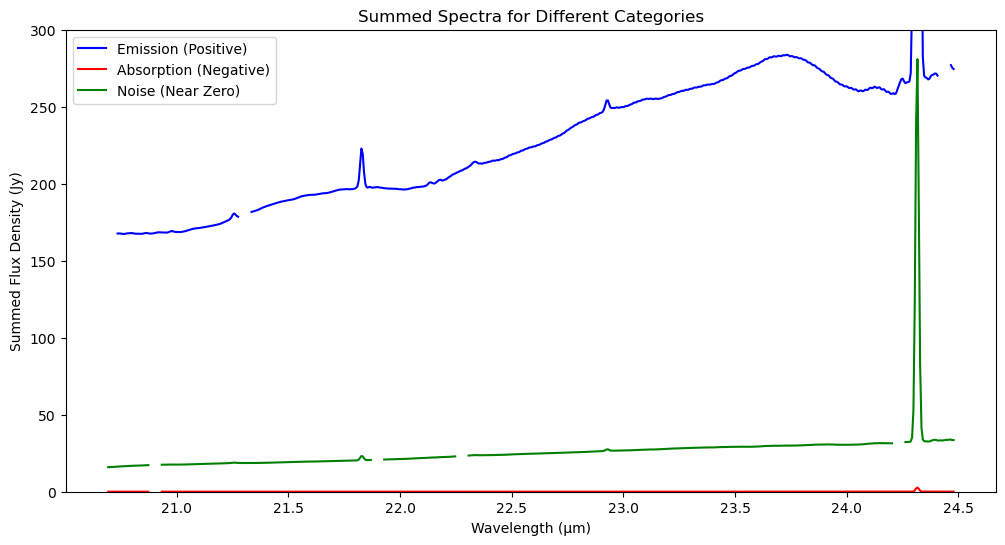

Categorized values saved to 'positive_values.txt', 'negative_values.txt', and 'near_zero_values.txt'.


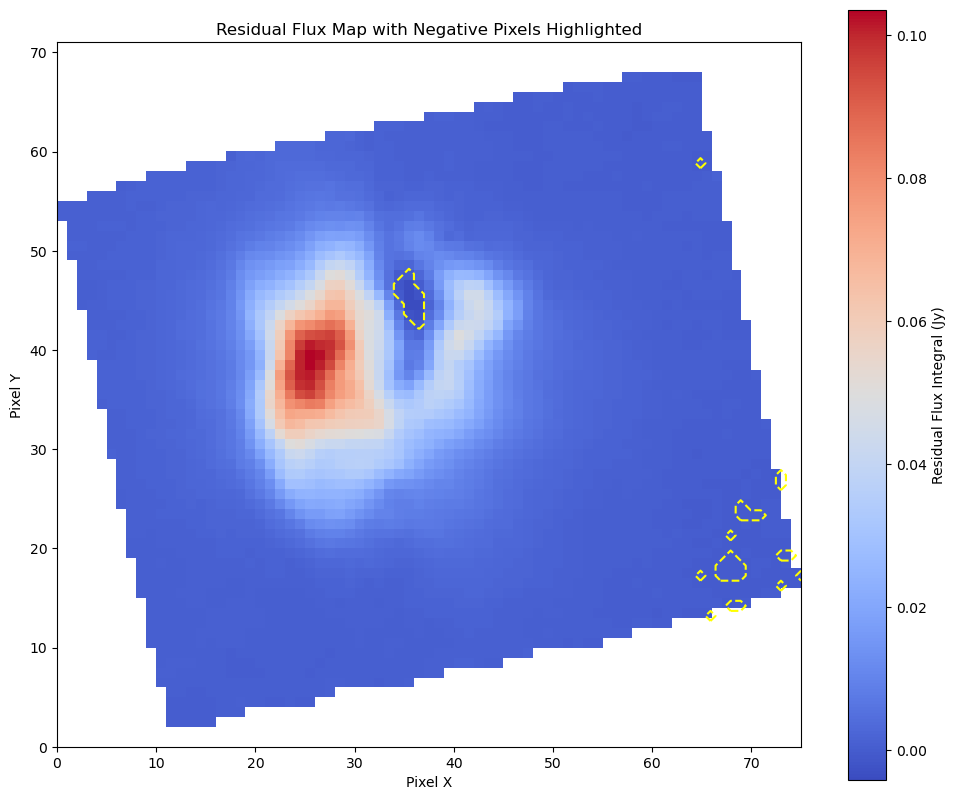

First 10 Negative Pixels (Y, X, Residual Flux Value):
Y: 13, X: 65, Value: -0.000169
Y: 14, X: 67, Value: -0.000375
Y: 14, X: 68, Value: -0.000274
Y: 16, X: 72, Value: -0.000177
Y: 17, X: 64, Value: -0.000176
Y: 17, X: 66, Value: -0.000205
Y: 17, X: 67, Value: -0.000308
Y: 17, X: 68, Value: -0.000247
Y: 17, X: 74, Value: -0.000322
Y: 18, X: 66, Value: -0.000205
Y: 18, X: 67, Value: -0.000277
Y: 18, X: 68, Value: -0.000233
Y: 19, X: 67, Value: -0.000198
Y: 19, X: 72, Value: -0.000170
Y: 19, X: 73, Value: -0.000200
Y: 21, X: 67, Value: -0.000277
Y: 23, X: 68, Value: -0.000239
Y: 23, X: 69, Value: -0.000252
Y: 23, X: 70, Value: -0.000315
Y: 24, X: 68, Value: -0.000225
Y: 26, X: 72, Value: -0.000278
Y: 27, X: 72, Value: -0.000385
Y: 42, X: 36, Value: -0.000500
Y: 43, X: 35, Value: -0.002387
Y: 43, X: 36, Value: -0.002949
Y: 44, X: 35, Value: -0.003748
Y: 44, X: 36, Value: -0.003748
Y: 45, X: 34, Value: -0.000555
Y: 45, X: 35, Value: -0.004134
Y: 45, X: 36, Value: -0.002318
Y: 46, X: 34, Va

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpdaf.obj import Cube
from astropy import units as u
from scipy.ndimage import gaussian_filter1d
import warnings

warnings.filterwarnings("ignore")


cube_path = '/Users/mary/Fits image of JWST/ngc6302_ch4-medium_s3d.fits'
cube = Cube(cube_path)
cube_data = cube.data
wavelengths = cube.wave.coord() 

pixel_size_arcsec = cube.wcs.get_step(unit=u.arcsec)[0]  
solid_angle = (pixel_size_arcsec * u.arcsec).to(u.rad)**2 
feature_range = (22.4, 24.05) 

residual_flux_map = np.full((cube_data.shape[1], cube_data.shape[2]), np.nan)
positive_values = [] 
negative_values = []  
near_zero_values = [] 

positive_sum_spectrum = np.zeros_like(wavelengths)
negative_sum_spectrum = np.zeros_like(wavelengths)
zero_sum_spectrum = np.zeros_like(wavelengths)

def calculate_feature_flux_integral(flux_density, continuum_line, wavelengths, feature_mask):
    """
    Calculate the integral of (I_lambda - I_0_lambda) over the specified wavelength range.
    """
    residual_flux = flux_density[feature_mask] - continuum_line[feature_mask]
    feature_wavelengths = wavelengths[feature_mask]
    integral = np.trapz(residual_flux, feature_wavelengths)
    return integral

noise_std = np.nanstd(cube_data)


for y in range(cube_data.shape[1]):
    for x in range(cube_data.shape[2]):
        spectrum = cube_data[:, y, x]
        
        if np.all(np.isnan(spectrum)):
            continue

        flux_density = spectrum * solid_angle.value * 1e6  

        smoothed_flux_density = gaussian_filter1d(flux_density, sigma=1)
        left_point = np.argmin(np.abs(wavelengths - feature_range[0]))
        right_point = np.argmin(np.abs(wavelengths - feature_range[1]))
        continuum_line = np.interp(
            wavelengths,
            [wavelengths[left_point], wavelengths[right_point]],
            [smoothed_flux_density[left_point], smoothed_flux_density[right_point]],
        )

        feature_mask = (wavelengths >= feature_range[0]) & (wavelengths <= feature_range[1])
        noise_region = (wavelengths < feature_range[0] - 0.5) | (wavelengths > feature_range[1] + 0.5)
        
        if np.sum(~np.isnan(smoothed_flux_density[noise_region])) > 0:
            noise_std = np.nanstd(smoothed_flux_density[noise_region])
        else:
            noise_std = noise_std  

        integral = calculate_feature_flux_integral(smoothed_flux_density, continuum_line, wavelengths, feature_mask)
        residual_flux_map[y, x] = integral

        if integral > 1 * noise_std:
            positive_values.append((x, y, integral))
            positive_sum_spectrum += smoothed_flux_density
        elif integral < -1 * noise_std:
            negative_values.append((x, y, integral))
            negative_sum_spectrum += smoothed_flux_density
        elif -1 * noise_std <= integral <= 1 * noise_std:
            near_zero_values.append((x, y, integral))
            zero_sum_spectrum += smoothed_flux_density

np.savetxt("positive_values.txt", positive_values, header="X Y Residual_Flux_Integral (Net Positive)", fmt="%.6f")
np.savetxt("negative_values.txt", negative_values, header="X Y Residual_Flux_Integral (Net Negative) Wavelength", fmt="%.6f")
np.savetxt("near_zero_values.txt", near_zero_values, header="X Y Residual_Flux_Integral (Noise/No Feature)", fmt="%.6f")

plt.figure(figsize=(12, 6))
plt.plot(wavelengths, positive_sum_spectrum, label="Emission (Positive)", color="blue")
plt.plot(wavelengths, negative_sum_spectrum, label="Absorption (Negative)", color="red")
plt.plot(wavelengths, zero_sum_spectrum, label="Noise (Near Zero)", color="green")
plt.title("Summed Spectra for Different Categories")
plt.xlabel("Wavelength (µm)")
plt.ylabel("Summed Flux Density (Jy)")
plt.legend()
plt.ylim(0,300)
plt.savefig("Summed_Spectra.png", dpi=300)
plt.show()

print("Categorized values saved to 'positive_values.txt', 'negative_values.txt', and 'near_zero_values.txt'.")

negative_value_mask = residual_flux_map < -1 * noise_std

plt.figure(figsize=(12, 10))
plt.imshow(
    residual_flux_map,
    origin="lower",
    cmap="coolwarm",
    extent=(0, cube_data.shape[2], 0, cube_data.shape[1]),
)
plt.colorbar(label="Residual Flux Integral (Jy)")
plt.title("Residual Flux Map with Negative Pixels Highlighted")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
plt.contour(
    negative_value_mask,
    levels=[0.5],
    colors="yellow",
    linewidths=1.5,
    linestyles="--",
    extent=(0, cube_data.shape[2], 0, cube_data.shape[1]),
    label="Negative Pixels"
)

plt.savefig("Residual_Flux_Map_Negative_Highlighted.png", dpi=300)
plt.show()

negative_pixel_indices = np.argwhere(negative_value_mask)
negative_pixel_values = residual_flux_map[negative_value_mask]
negative_pixel_data = np.hstack((negative_pixel_indices, negative_pixel_values[:, np.newaxis]))
np.savetxt(
    "negative_pixels.txt",
    negative_pixel_data,
    fmt="%.6f",
    header="Y X Residual_Flux_Value",
)

print("First 10 Negative Pixels (Y, X, Residual Flux Value):")
for row in negative_pixel_data[:50]:
    print(f"Y: {int(row[0])}, X: {int(row[1])}, Value: {row[2]:.6f}")
